<a href="https://colab.research.google.com/github/Nicohim87/DeepLearning-AOL/blob/main/Model1/Model_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [36]:
import kagglehub

# Download latest version
DATASET_PATH = kagglehub.dataset_download("dionisiusdh/indonesian-batik-motifs")

print("Path to dataset files:", DATASET_PATH)

Path to dataset files: /root/.cache/kagglehub/datasets/dionisiusdh/indonesian-batik-motifs/versions/1


In [37]:
img = tf.keras.utils.load_img(os.path.join(DATASET_PATH, 'batik-megamendung/1.jpg'), color_mode='grayscale')
img = tf.keras.utils.img_to_array(img)
img.shape

(960, 1280, 1)

In [38]:
CHOSEN_CLASSNAME = ['batik-megamendung', 'batik-tambal', 'batik-parang']
INPUT_SHAPE = (400, 400)

images = []
classes = []

In [39]:
from PIL import Image, UnidentifiedImageError

In [40]:
for i, classname in enumerate(CHOSEN_CLASSNAME):
    for j, filename in enumerate(os.listdir(os.path.join(DATASET_PATH, classname))):
        try:
          img = tf.keras.utils.load_img(os.path.join(DATASET_PATH, classname, filename), color_mode='rgb', target_size=INPUT_SHAPE)
          img = tf.keras.utils.img_to_array(img)
          img = img/255
          images.append(img)
          classes.append(i)
        except UnidentifiedImageError:
          print(f"Skipping {classname}/{filename}: Img unidentified")
        except Exception as e:
          print(f"Skipping {classname}/{filename}: An error occurred - {e}")

Skipping batik-megamendung/49.jpg: Img unidentified


[]

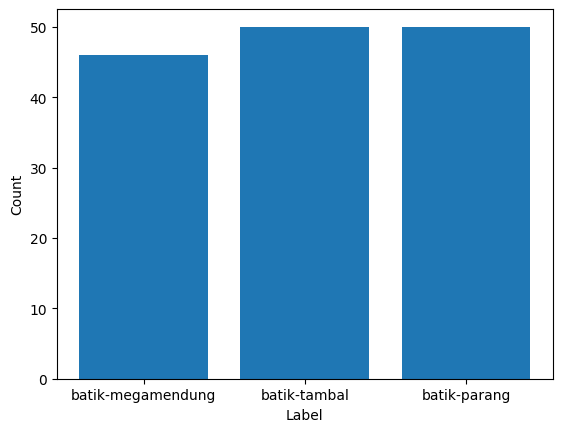

In [41]:
label, count = np.unique(classes, return_counts=True) # Menghitung jumlah kemunculan dari suatu label
# Plotting
plt.bar(label, count)
plt.ylabel("Count")
plt.xlabel("Label")
plt.xticks([0, 1, 2],CHOSEN_CLASSNAME)
plt.plot()

In [42]:
images = np.array(images)
classes = np.array(classes)

In [43]:
y = tf.keras.utils.to_categorical(classes, num_classes=len(CHOSEN_CLASSNAME))
y.shape

(146, 3)

In [44]:
images.shape

(146, 400, 400, 3)

# **Train Test Splitting**

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
x_train, x_temp, y_train, y_temp = train_test_split(images, y, train_size=0.7)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

[]

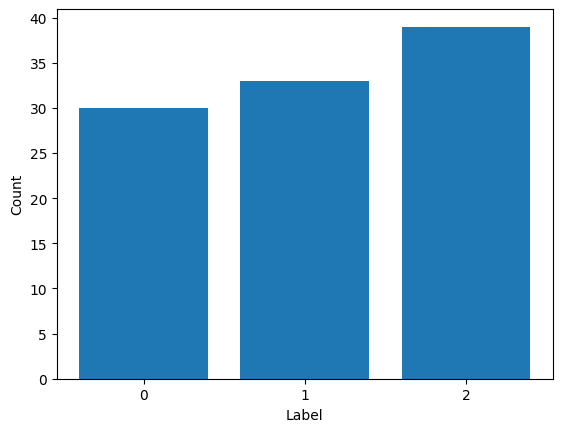

In [47]:
ylabel = [np.argmax(i) for i in y_train]

label, count = np.unique(ylabel, return_counts=True) # Menghitung jumlah kemunculan dari suatu label
# Plotting
plt.bar(label, count)
plt.ylabel("Count")
plt.xlabel("Label")
plt.xticks(CHOSEN_CLASSNAME)
plt.plot()

# **Augmentation**

In [48]:
CLASS_SIZE = 50

In [49]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_flip_up_down(image)  # Random horizontal flip
    image = tf.image.random_brightness(image, max_delta=0.1)  # Random brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Random contrast
    return image, label

def generate_data(x_train, y_train, size):
    # Initial Shuffle
    permutation = np.random.permutation(len(x_train))

    x_train = x_train[permutation]
    y_train = y_train[permutation]

    # Data Generation
    permutation = np.random.permutation(size)
    permutation %= len(x_train)

    x_train_generated = []
    y_train_generated = []
    for i in permutation:
        x_gen, y_gen = augment_image(x_train[i], y_train[i])
        x_train_generated.append(x_gen)
        y_train_generated.append(y_gen)

    return x_train_generated, y_train_generated

In [50]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train_augmented = []
y_train_augmented = []
for i in range(len(CHOSEN_CLASSNAME)):
    indices = np.where(y_train[:, i] == 1)[0]

    x_aug, y_aug = generate_data(x_train[indices], y_train[indices], CLASS_SIZE)
    x_train_augmented.extend(x_aug)
    y_train_augmented.extend(y_aug)

In [51]:
x_train_augmented = np.array(x_train_augmented)
y_train_augmented = np.array(y_train_augmented)

permutation = np.random.permutation(len(x_train_augmented))

x_train_augmented = x_train_augmented[permutation]
y_train_augmented = y_train_augmented[permutation]

In [52]:
x_train_augmented.shape

(150, 400, 400, 3)

[]

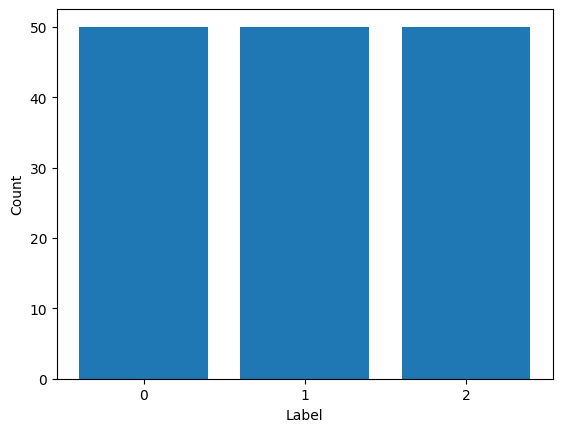

In [90]:
ylabel = [np.argmax(i) for i in y_train_augmented]

label, count = np.unique(ylabel, return_counts=True) # Menghitung jumlah kemunculan dari suatu label
# Plotting
plt.bar(label, count)
plt.ylabel("Count")
plt.xlabel("Label")
plt.xticks(label)
plt.plot()

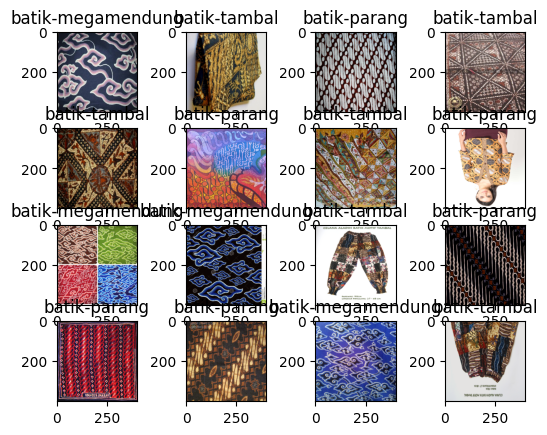

In [54]:
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train_augmented[i], cmap='gray')
    plt.title(CHOSEN_CLASSNAME[np.argmax(y_train_augmented[i])])

# **Model**

In [55]:
from tensorflow.keras.optimizers import Adam

In [78]:
EPOCHS = 20
BATCH_SIZE = 25
LEARNING_RATE = 1e-4

In [79]:
input = tf.keras.layers.Input(shape=x_train_augmented[0].shape)


x = tf.keras.layers.Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='same')(input)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)

x = tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)

x = tf.keras.layers.Conv2D(64, kernel_size=(5,5), strides=(2,2))(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(3,3))(x)

x = tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(175)(x)
x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(100)(x)
x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Dense(16)(x)
x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)
x = tf.keras.layers.BatchNormalization()(x)

output = tf.keras.layers.Dense(len(CHOSEN_CLASSNAME), activation='softmax')(x)

In [80]:
model= tf.keras.Model(inputs=input, outputs=output)

optimizer = Adam(learning_rate = LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 400, 400, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 400, 400, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_16 (ReLU)                      │ (None, 400, 400, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 200, 200, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 200, 200, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_17 (ReLU)                      │ (None, 200, 200, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 48, 48, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_18 (ReLU)                      │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_19 (ReLU)                      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_20 (LeakyReLU)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 175)                 │          44,975 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_21 (LeakyReLU)           │ (None, 175)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 175)                 │             7

 Total params: 2,300,190 (8.77 MB)

 Trainable params: 2,298,968 (8.77 MB)

 Non-trainable params: 1,222 (4.77 KB)

In [81]:
hist = model.fit(x_train_augmented, y_train_augmented, validation_data = (x_val, y_val), epochs = EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 408ms/step - accuracy: 0.3718 - loss: 1.4251 - val_accuracy: 0.1364 - val_loss: 1.1081
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.4365 - loss: 1.2301 - val_accuracy: 0.1818 - val_loss: 1.1112
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.4165 - loss: 1.2318 - val_accuracy: 0.1818 - val_loss: 1.1151
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5356 - loss: 0.9879 - val_accuracy: 0.1818 - val_loss: 1.1154
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5287 - loss: 1.0449 - val_accuracy: 0.1818 - val_loss: 1.1045
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6079 - loss: 1.0228 - val_accuracy: 0.4545 - val_loss: 1.0899
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6149 - loss: 0.9598 - val_accuracy: 0.4545 - val_loss: 1.0759
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5989 - loss: 0.8909 - val_accuracy: 0.4545 - val_loss: 1.

# **Evaluation**

In [82]:
from sklearn import metrics

In [83]:
loss, accuracy = model.evaluate(x_test, y_test, verbose = 1)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.3636 - loss: 1.0708
Loss: 1.070777416229248
Accuracy: 0.3636363744735718


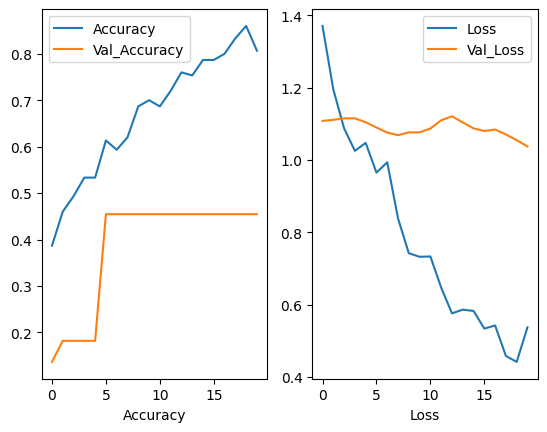

In [84]:
# Accuracy
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('Epochs')
plt.xlabel('Accuracy')
plt.legend(['Accuracy', "Val_Accuracy"])

# Loss
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.legend(['Loss', "Val_Loss"])

# Tampilkan Plot
plt.show()

In [85]:
pred = model.predict(x_test) # Flatten untuk memastikan bahwa output hanya berupa 1D array

pred = [CHOSEN_CLASSNAME[np.argmax(i)] for i in pred] # Mendecode hasil prediksi nya, index perlu di bulatkan karena fungsi sigmoid normalnya tidak menghasilkan bilangan bulat
actual = [CHOSEN_CLASSNAME[np.argmax(i)] for i in y_test] # Mendecode nilai asli nya

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step


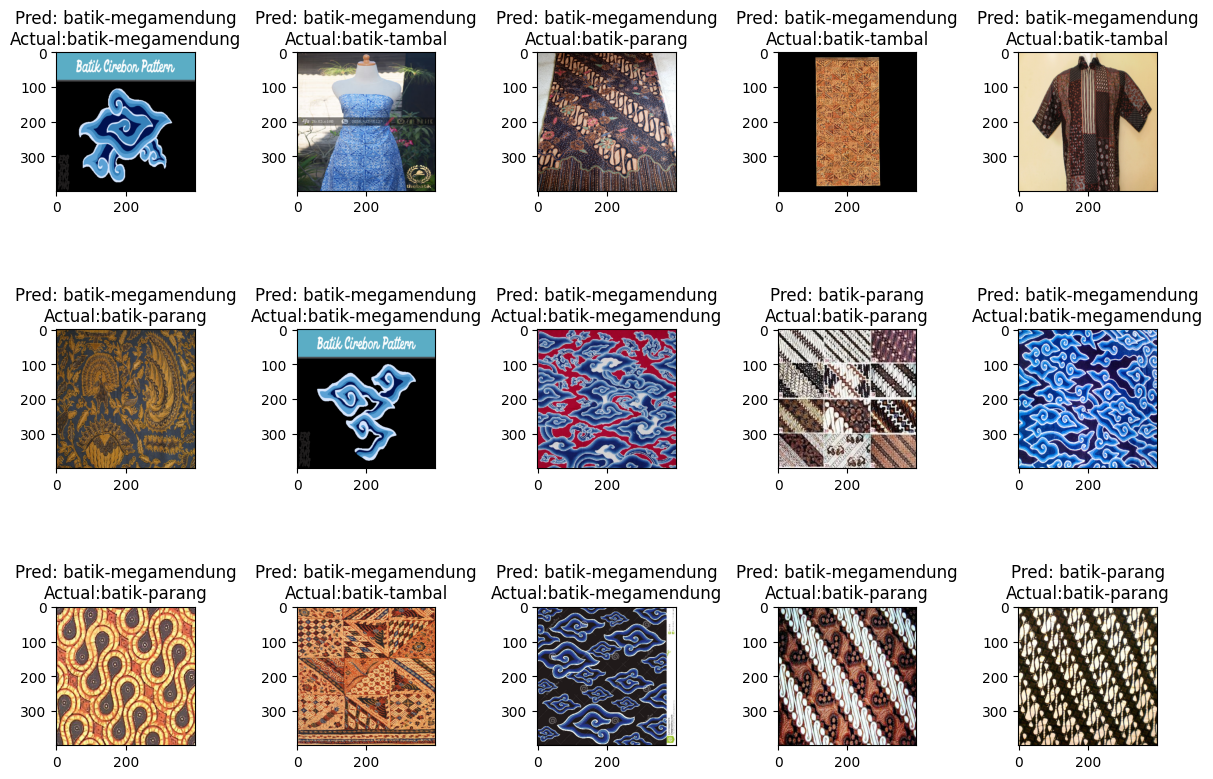

In [86]:
plt.figure(figsize=(15,9)) # Menentukan ukuran plot
for i in range(15):
    plt.subplot(3, 5, i+1) # Menentukan lokasi subplot nya
    plt.imshow(x_test[i], cmap='gray') # Menampilkan gambar

    plt.title(f"Pred: {pred[i]}\nActual:{actual[i]}") # Menampilkan actual value dan prediction nya

plt.subplots_adjust(hspace=1)

In [87]:
print(metrics.classification_report(pred, actual))

                   precision    recall  f1-score   support

batik-megamendung       1.00      0.30      0.46        20
     batik-parang       0.25      1.00      0.40         2
     batik-tambal       0.00      0.00      0.00         0

         accuracy                           0.36        22
        macro avg       0.42      0.43      0.29        22
     weighted avg       0.93      0.36      0.46        22



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


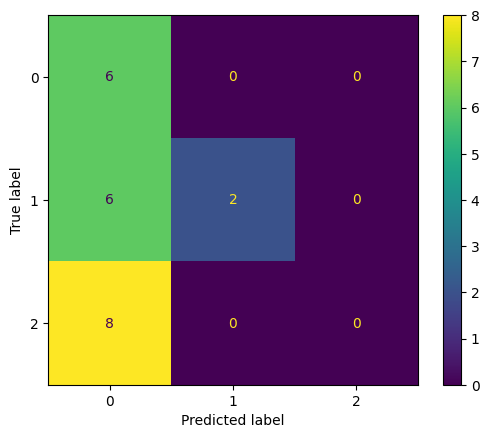

In [92]:
CM = metrics.confusion_matrix(actual, pred) # Membuat confusion matrix nya
fig = metrics.ConfusionMatrixDisplay(CM) # Display labels agar label yang ditunjukan sudah di decode
fig.plot() # Plot confusion matrix nya